TP 4 : Détecteur de SPAM
=======

1 - Introduction 
------

L'objectif de ce TP est de réaliser un détecteur de SPAM.

Il sera à réaliser en python 3. Les librairies utilisées sont installées sur les machines de l'université, vous pouvez néanmoins les installer sur vos propres machines à l'aide de l'utilitaire pip présent par défaut avec python.
	
N'hésitez pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

- Python 3: https://docs.python.org/3/
- Numpy: https://docs.scipy.org/doc/numpy/reference/
- Scipy: https://docs.scipy.org/doc/scipy/reference/
- Matplotilb: https://matplotlib.org/contents.html
- Scikit-learn: http://scikit-learn.org

In [2]:
import os
import gzip
    
import numpy as np
from matplotlib import pyplot as plt

import sklearn as sk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model

from sklearn.metrics import *

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

print(sk.__version__)

0.22.1


2 -  Analyse des données
-----

Nous allons dans ce TP travailler sur une base de SMS se trouvant à l'adresse https://archive.ics.uci.edu/ml/datasets/sms+spam+collection . Elle contient 5574 SMS classé en deux catégories (SPAM et HAM). L'objectif est d'arrivé à filtrer les SPAM pour ne garder que les messages acceptables.

### 2.1 - Lecture de la base de données 

En utilisant la fonction `np.loadtxt` de numpy, charger la base de donnée de SMS contenu dans le fichier `SMSSpamCollection.txt`. Les éléments sont de type chaine de caractère (`str`) et le délimiteur entre les éléments est la tabulation (`\t`). 

La première colonne contiendra le label (`ham` ou `spam`) et la deuxième contiendra le texte à évaluer. Chaque ligne correspond à un exemple de la base d'apprentissage.

In [3]:
data = np.loadtxt("SMSSpamCollection.txt", delimiter="\t", dtype=str)

Séparez la matrice de la question précédente en deux variables `X` et `y` qui contiendront respectivement le texte des messages et les annotations qui leur sont associées. 

In [4]:
X = data[:,1] # on recupere la 2eme colonne (texte du message)
y = data[:,0] # on recupere la 1ere ligne (spam ou ham)

Convertissez `y` en un vecteur contenant `1` lorsque le message est un `spam` et `0` sinon.

In [5]:
y[y=="spam"] = 1
y[y=="ham"] = 0
y = y.astype('int')
print(y)

[0 0 1 ... 0 0 0]


Affichez le nombre de `spam` et de `ham` dans la base en pourcentages (arrondis à 2 chiffres après la virgule).

In [6]:
nb_spam = np.sum(y)
print("pourcentage de spam : %0.2f" % (100 * nb_spam / y.shape[0]))
print("pourcentage de ham : %0.2f" % (100 * (y.shape[0] - nb_spam)/ y.shape[0]))

pourcentage de spam : 13.40
pourcentage de ham : 86.60


À votre avis les classes sont-elles équilibrées ? Cela peut-il avoir une importance pour l'apprentissage ? 

### 2.2 - Construction d'un descripteur sur du texte

Nous allons dans cette partie construire un descripteur simple sur texte. Pour chaque message nous allons compter le nombre d'apparition de chaque mot présent dans le corpus. Ainsi chaque exemple de la base de données sera représenté par un vecteur d'entier de la taille du dictionnaire (ensemble de tout les mots possibles).

Pour construire le classifieur décrit ci-dessus, vous pouvez utiliser la classe `CountVectorizer` ( https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html ) de scikit-learn. Créez un objet de type `CountVectorizer` puis utilisez la méthode `fit_transform` sur nos données pour extraire le descripteur de chaque message. Le résultat est stocké dans un tableau numpy sparse (seul les valeurs non nulles sont réellement stockées) que vous nommerez `descr_X`.

In [7]:
cv = CountVectorizer()
descr_X = cv.fit_transform(X)
print(descr_X)
# (sms num, mot num) : nb apparition du numieme mot dans le numieme sms

  (0, 8174)	1
  (0, 1071)	1
  (0, 3562)	1
  (0, 7553)	1
  (0, 2037)	1
  (0, 1740)	1
  (0, 4423)	1
  (0, 8398)	1
  (0, 3601)	1
  (0, 1742)	1
  (0, 4049)	1
  (0, 5466)	1
  (0, 1298)	1
  (0, 2311)	1
  (0, 5849)	1
  (0, 4300)	1
  (0, 7938)	1
  (0, 3519)	1
  (1, 5462)	1
  (1, 8301)	1
  (1, 4268)	1
  (1, 4456)	1
  (1, 5436)	1
  (2, 77)	1
  (2, 1156)	1
  :	:
  (5572, 1777)	1
  (5572, 3438)	1
  (5572, 2862)	1
  (5572, 6969)	1
  (5572, 1769)	1
  (5572, 7974)	1
  (5572, 2568)	1
  (5572, 5267)	1
  (5572, 1431)	1
  (5572, 7533)	1
  (5572, 3275)	1
  (5572, 6959)	1
  (5572, 4560)	1
  (5572, 1086)	1
  (5572, 8221)	1
  (5572, 4174)	1
  (5572, 3748)	1
  (5572, 7665)	1
  (5572, 3324)	1
  (5572, 4049)	1
  (5573, 6423)	1
  (5573, 7794)	1
  (5573, 4181)	2
  (5573, 5178)	1
  (5573, 7665)	1


En utilisant la méthode `get_feature_names` de l'objet de type `CountVectorizer` créé à la question précédente, récupérez l'ensemble des mots du corpus. Combien y-a-t-il de mot en tout ? 

In [8]:
mots = cv.get_feature_names()
print("Nombres de mots dans les messages :", len(mots))

Nombres de mots dans les messages : 8566


Quel est le mot numéro 2196 dans la liste des mots du corpus ? 

In [9]:
print("Mot 2196 :", mots[2196])

Mot 2196 : configure


Combien de fois apparait le mot numéro 2196 dans le message numéro 4937 ? 

In [10]:
print("Nombre d'apparition de \"", mots[2196], "\" dans le message 4937 :", descr_X[(4937, 2196)])

Nombre d'apparition de " configure " dans le message 4937 : 0


Compter le nombre d'apparition de chaque mot dans le corpus. Affichez une courbe du nombre d'apparition de chaque mot trié du mot le moins fréquent au mot le plus fréquent.

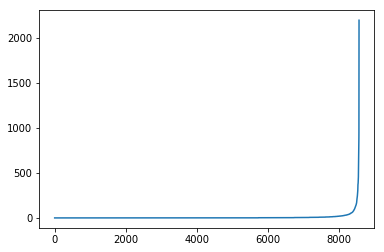

In [11]:
count_mot = np.sum(descr_X.toarray(), 0)
plt.plot(np.sort(count_mot))
plt.show()

En utilisant la fonction `plt.spy` de matplotlib ( https://matplotlib.org/api/_as_gen/matplotlib.pyplot.spy.html ) permettant l'affichage de matrice sparse, affichez sous forme d'image les vecteurs de la base de données. Mettez en rouge les mots apparaissant plus de 3 fois dans un message. 

Les lignes de cet affichage correspondent aux messages et les colonnes aux mots du corpus. 

Utilisez l'attribut `markersize` pour changer la taille des points et rendre la figure plus lisible.

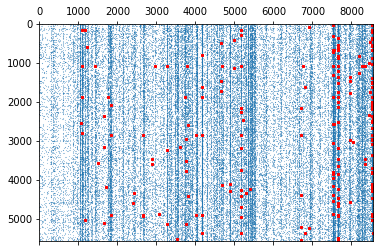

In [12]:
plt.spy(descr_X, markersize=0.1)
plt.spy(descr_X, 3, markersize=2, c="red")

Que pouvez-vous dire sur la répartition des mots dans le corpus ? 

3 - Détecteur de spam
---------

Découpez la base de données (avant calcul des descripteurs) en deux ensembles afin d'avoir 2/3 des exemples pour l’entraînement et 1/3 pour le test. 
Vérifier que les deux ensembles que vous avez créés ont le bon nombre d'exemple.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)
print("Taille de X_train:", X_train.shape)
print("Taille de X_test:", X_test.shape)
print("Taille de y_train:", y_train.shape)
print("Taille de y_test:", y_test.shape)

Taille de X_train: (3716,)
Taille de X_test: (1858,)
Taille de y_train: (3716,)
Taille de y_test: (1858,)


Testez les performances d'un classifieur aléatoire. Pour cela créez un vecteur `y_pred` contenant des 0 et des 1 tirés aléatoirement. Mesurez la performance de ces prédictions avec comme critère l'`accuracy`.

In [32]:
y_pred = np.random.randint(2, size=y_test.shape[0])
acc = accuracy_score(y_test, y_pred)
print("Accuracy d un classifieur aléatoire:", acc)

Accuracy d un classifieur aléatoire: 0.48008611410118407


Faites de même avec pour critère de comparaison la matrice de confusion:

In [33]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:\n", conf_mat)

Matrice de confusion:
 [[759 833]
 [133 133]]


Donnez les scores d'aire sous la courbe ROC et sous la courbe de précission/rappel:

In [34]:
roc_auc = roc_auc_score(y_test, y_pred)
average_pre = average_precision_score(y_test, y_pred)
print("Aire sous la courbe ROC d un classifieur aléatoire:", roc_auc)
print("Aire sous la courbe Rappel/Précission d un classifieur aléatoire:", average_pre)

Aire sous la courbe ROC d un classifieur aléatoire: 0.4883793969849246
Aire sous la courbe Rappel/Précission d un classifieur aléatoire: 0.14042292631940217


Testez les performances d'un classifieur qui répond toujours `SPAM`.

In [35]:
y_pred = np.ones(y_test.shape[0])
acc = accuracy_score(y_test, y_pred)
print("Accuracy d un classifieur répondant toujours SPAM:", acc)
conf_mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion d un classifieur répondant toujours SPAM:\n", conf_mat)

roc_auc = roc_auc_score(y_test, y_pred)
average_pre = average_precision_score(y_test, y_pred)
print("Aire sous la courbe ROC d un classifieur répondant toujours SPAM:", roc_auc)
print("Aire sous la courbe Rappel/Précission d un classifieur répondant toujours SPAM:", average_pre)

Accuracy d un classifieur répondant toujours SPAM: 0.14316469321851452
Matrice de confusion d un classifieur répondant toujours SPAM:
 [[   0 1592]
 [   0  266]]
Aire sous la courbe ROC d un classifieur répondant toujours SPAM: 0.5
Aire sous la courbe Rappel/Précission d un classifieur répondant toujours SPAM: 0.14316469321851452


Testez les performances d'un classifieur qui répond toujours `HAM`.

In [36]:
y_pred = np.zeros(y_test.shape[0])
acc = accuracy_score(y_test, y_pred)
print("Accuracy d un classifieur répondant toujours HAM:", acc)
conf_mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion d un classifieur répondant toujours HAM:\n", conf_mat)

roc_auc = roc_auc_score(y_test, y_pred)
average_pre = average_precision_score(y_test, y_pred)
print("Aire sous la courbe ROC d un classifieur répondant toujours HAM:", roc_auc)
print("Aire sous la courbe Rappel/Précission d un classifieur répondant toujours HAM:", average_pre)

Accuracy d un classifieur répondant toujours HAM: 0.8568353067814855
Matrice de confusion d un classifieur répondant toujours HAM:
 [[1592    0]
 [ 266    0]]
Aire sous la courbe ROC d un classifieur répondant toujours HAM: 0.5
Aire sous la courbe Rappel/Précission d un classifieur répondant toujours HAM: 0.14316469321851452


Que pouvez-vous faire comme analyse des performances de ces différents classifeurs ? 

Le code suivant met en place un pipeline permettant à la fois de calculer les descripteurs et d'effectuer la classification. On utilise ici un SVM avec les paramètres par défaut. On a néanmoins pris en compte le déséquilibre des classes lors de l'apprentissage.

In [37]:
%%time
pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=1)), 
        ('classifier',svm.LinearSVC(class_weight= 'balanced'))
    ])

pipeline.set_params().fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('Hello')
print('Accuracy d un classifieur SVM  (par défaut):',accuracy_score(y_test,y_pred))
print('Matrice de confusion d un classifieur SVM  (par défaut):\n',confusion_matrix(y_test,y_pred))


print('Aire sous la courbe ROC d un classifieur SVM  (par défaut):',roc_auc_score(y_test,y_pred))
print('Aire sous la courbe Rappel/Précission d un classifieur SVM (par défaut):',average_precision_score(y_test,y_pred))

Hello
Accuracy d un classifieur SVM  (par défaut): 0.9833153928955867
Matrice de confusion d un classifieur SVM  (par défaut):
 [[1586    6]
 [  25  241]]
Aire sous la courbe ROC d un classifieur SVM  (par défaut): 0.9511230966864396
Aire sous la courbe Rappel/Précission d un classifieur SVM (par défaut): 0.8974619034523199
Wall time: 190 ms


Faites une cross-validation des paramètres d'un SVM linéaire pour les valeurs de C suivantes: 1e-2 , 1e-1 , 1. Vous utiliserez comme critère de score, l'aire sous la courbe de précision/rappel.

In [66]:
pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=1)), 
        ('classifier',svm.LinearSVC(class_weight= 'balanced'))
    ])

pipeline.set_params()

# http://queirozf.com/entries/scikit-learn-pipeline-examples
param_grid = {
    'classifier__C':[1e-2 , 1e-1 , 1]
}

clf_grid = GridSearchCV(pipeline,
       param_grid=param_grid, cv=5, scoring='average_precision')

clf_grid.fit(X_train, y_train)

print('\033[34mMeilleur jeu de paramètre trouvé parmi les paramètres proposés:\033[0m')
print(clf_grid.best_estimator_,'\n')
print("\033[34mGrille des scores par combinaison de paramètres testés:\033[0m")
    
elements = clf_grid.cv_results_
for i in np.argsort(elements['mean_test_score']):
    print("%0.3f (+/-%0.03f) for %r"% (elements['mean_test_score'][i],
                                       elements['std_test_score'][i],
                                       elements['params'][i]))

Meilleur jeu de paramètre trouvé parmi les paramètres proposés:
Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LinearSVC(C=0.1, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class

0.971 (+/-0.006) for {'classifier__C': 0.01}
0.975 (+/-0.007) for {'classifier__C': 0.1}
0.975 (+/-0.008) for {'classifier__C': 1}


Récupérez le meilleur classifieur est placez le dans une variable `clf_best`.

In [68]:
clf_best = clf_grid.best_estimator_
print(clf_best)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LinearSVC(C=0.1, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                       

Testez d'autre combinaison de paramètres pour améliorer les performances.

In [78]:
%%time
pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=1)), 
        ('classifier',svm.LinearSVC(C=1,class_weight= 'balanced'))
    ])

pipeline.set_params().fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('Hello')
print('Accuracy d un classifieur SVM  (par défaut):',accuracy_score(y_test,y_pred))
print('Matrice de confusion d un classifieur SVM  (par défaut):\n',confusion_matrix(y_test,y_pred))


print('Aire sous la courbe ROC d un classifieur SVM  (par défaut):',roc_auc_score(y_test,y_pred))
print('Aire sous la courbe Rappel/Précission d un classifieur SVM (par défaut):',average_precision_score(y_test,y_pred))

Hello
Accuracy d un classifieur SVM  (par défaut): 0.9833153928955867
Matrice de confusion d un classifieur SVM  (par défaut):
 [[1586    6]
 [  25  241]]
Aire sous la courbe ROC d un classifieur SVM  (par défaut): 0.9511230966864396
Aire sous la courbe Rappel/Précission d un classifieur SVM (par défaut): 0.8974619034523199
Wall time: 200 ms
